# PROJET - Problème au valeurs propres - Analyse de phénomènes dispersifs
**4ModIA**

Julien Blanchon & Hamza Belkarkor

In [1]:
# Import libraries
import numpy as np
import numpy.linalg as npl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

On souhaite étudier dans ce projet le comportement d’un produit déversé dans une rivière de longeur $a$ (`a = 20`) et de largeur $b$ (`b = 10`) constante et animée d’une vitesse $V$ (`V = 2`). Ce produit est supposé peu miscible à l’eau et moins dense que l’eau (par exemple de l’huile), de sorte qu’il flotte à la surface de l’eau.

On note $C(x, y, t)$ et $\rho(x, y, t)$ la concentration et la masse volumique du liquide, respectivement, à la position $(x, y)$ et à l’instant $t$. Ces deux quantités les équations de la conservation de la conservation de la masse et de la concentration, à savoir: 
$$\begin{aligned}
&\frac{\partial \rho}{\partial t}+\operatorname{div}(\rho V)=0 \\
&\frac{\partial \rho C}{\partial t}+\operatorname{div}(\Phi)=0
\end{aligned}$$

La grandeur $\Phi$ correspond aux flux dispersifs qui sont de deux natures :
- Les *flux diffusifs*, donnés par $\Phi_{d}=-\lambda \nabla C$ avec $λ$ le coefficient de diffusion que l’on supposera constant.
- Les *flux advectifs*, donnés par $\Phi_{c}=\rho C V$

Le flux total correspond à la somme de ces deux flux : $\Phi=\Phi_{c}+\Phi_{d} = -\lambda \nabla C + \rho C V$

In [2]:
xmin = 0.0
xmax = 1.8 ## Pour a = b 1
a = xmax - xmin
ymin = 0.0
ymax = 1.0
b = ymax - ymin
V = 2

# Introduction

## Question 1

Montrer que :

$$\frac{\partial C}{\partial t}-\mu \Delta C+V \cdot \nabla C=0$$ 

avec $µ$ un coefficient de diffusion que l’on déterminera.

> Avec l'équation de la conservation de la concentration $$\begin{aligned}
&\frac{\partial \rho C}{\partial t}+\operatorname{div}( \underbrace{\Phi}_{-\lambda \nabla C + \rho C V})=0 \\
&\frac{\partial \rho C}{\partial t}+\operatorname{div}(-\lambda \nabla C + \rho C V)=0 
\end{aligned}$$
> Avec $\frac{\partial \rho C}{\partial t} = \rho \frac{\partial C}{\partial t} + C \frac{\partial \rho}{\partial t}$ et $\operatorname{div}(-\lambda \nabla C + \rho C V) = -\lambda \operatorname{div}(\nabla C) + \operatorname{div}(\rho C V) = -\lambda \Delta C + \rho V \cdot \nabla C + C\operatorname{div}(\rho V)$
> 
> Ce qui donne : $$\begin{aligned}
&\rho \frac{\partial C}{\partial t} + C \frac{\partial \rho}{\partial t} + -\lambda \Delta C + \rho V \cdot \nabla C + C\operatorname{div}(\rho V) = 0 \\
&\rho \frac{\partial C}{\partial t} + -\lambda \Delta C + \rho V \cdot \nabla C + \underbrace{\big( C \frac{\partial \rho}{\partial t} + C\operatorname{div}(\rho V) \big )}_{\frac{\partial \rho}{\partial t}+\operatorname{div}(\rho V)=0 \text{ Conservation de la masse}}= 0 \\
&\rho \frac{\partial C}{\partial t} + -\lambda \Delta C + \rho V \cdot \nabla C = 0 \\
& \frac{\partial C}{\partial t} + -\underbrace{\frac{\lambda}{\rho}}_{\mu} \Delta C + V \cdot \nabla C = 0 \\
& \frac{\partial C}{\partial t} + -\mu \Delta C + V \cdot \nabla C = 0
\end{aligned}$$
> 
> En conclusion on à :
> $$\underbrace{\frac{\partial C}{\partial t} + -\mu \Delta C}_{\text{Equation de la chaleur}} + \underbrace{V \cdot \nabla C}_{\text{Advection}} = 0$$

L’objectif de ce projet est de résoudre ce problème en supposant le coefficient $µ$ constant et dans le cas ou la rivière est animée d’une vitesse $V = (1, 0)$. Afin de simplifier ce problème, nous ne considérons qu’une portion de la rivière de longueur $a$. Le domaine sur lequel nous allons travaillé est ainsi noté $\Omega=] 0, a[\times] 0, b[$. Initialement, nous supposons que le produit se trouve à l’intérieur de $Ω$ et l’on distingue la frontière amont $Γ_0$ du reste de la frontière $Γ_1 = ∂Ω - Γ_0$, telles que l’on impose une condition de Dirichlet homogène sur $Γ_0$ et de Neumann homogène sur $Γ_1$. La condition sur $Γ_1$ permet au fluide de sortir dur domaine $Ω$ ; voir la figure 1.

![](/Users/julienblanchon/Git/julien-blanchon/Le-TP-de-Keunotor3/pb_au_vp/projet/fig1.png)

Le problème que l’on souhaite résoudre s’écrit ainsi :
$$\begin{array}{rlr}
\frac{\partial C}{\partial t}-\mu \Delta C+V \cdot \nabla C & =0 & & \text { dans } \Omega, \\
C & =0 & & \text { sur } \Gamma_{0}, \\
\frac{\partial C}{\partial n} & =0 & & \text { sur } \Gamma_{1}, \\
C(t=0) & =C_{0} & & \text { dans } \Omega .
\end{array}$$

Afin d’approcher la solution de ce problème, nous allons utiliser la méthode des différences finies. 

On considère un maillage cartésien de $Ω$ constitué de $N_x + 2$ points dans la direction $O_x$ et $N_y + 2$ points dans la direction $O_y$ (dans la largeur de la rivière). Les coordonnées des points du maillages correspondent à: $$x_{i}=\frac{i a}{N_{x}+1} \quad 0 \leq i \leq N_{x}+1, \quad y_{j}=\frac{j b}{N_{y}+1} \quad 0 \leq j \leq N_{y}+1$$ avec $$h_{x}=\frac{a}{N_{x}+1}, \quad h_{y}=\frac{b}{N_{y}+1}$$

En tout point $(x_i, y_j)$, la méthode des différences finies permet de déterminer une approximation $U_{i,j}$ de la quantité $C(x_i, y_j)$, la solution exacte évaluée en ces points.
Afin d’implémenter correctement la résolution du problème (2), nous procédons en plusieurs étapes. 

- Dans un premier temps, nous nous concentrons sur la discrétisation de l’opérateur Laplacien, pour lequel nous considérons des conditions mixtes Dirichlet/Neumann (non) homogènes. (**Approximation spatiale du Laplacien**)
- Après cela, nous étudions une discrétisation centrée du terme advectif.
- Et enfin nous terminons par regarder les aspects de discrétisation en temps. 

L’objectif de ce travail est de pouvoir prédire numériquement le comportement de ce produit à la surface de l’eau au cours du temps.


In [3]:
nptx = 16
nx = 16-2
npty = 16
ny = npty-2
hx = a/(nx+1)
hy = b/(ny+1)

In [4]:
x_int = range(1, nx+1)
y_int = range(1, ny+1)


In [5]:
xx = np.linspace(xmin, xmax, nptx)
yy = np.linspace(ymin, ymax, npty)
Ω = np.meshgrid(xx, yy)

# Approximation spatiale du Laplacien

Considérons pour commencer l’approximation de l’opérateur Laplacien en $2D$ sur l’ouvert $\Omega=] 0, a[\times] 0, b[$ avec des conditions à la limite de type Dirichlet homogène sur $∂Ω$ :

$$\begin{aligned}
-\mu \Delta u &=f \text { dans } \Omega \\
u &=0 \text { sur } \partial \Omega
\end{aligned}$$

avec $f: \Omega \rightarrow \mathbb{R}$ un terme source.

## Question 2

A $y_j$ fixé, montrer que:
$$-\frac{\partial^{2} u}{\partial x^{2}}\left(x_{i}, y_{j}\right)=\frac{2 u\left(x_{i}, y_{j}\right)-u\left(x_{i-1}, y_{j}\right)-u\left(x_{i+1}, y_{j}\right)}{h_{x}^{2}}+\mathcal{O}\left(h_{x}^{2}\right)$$

En déduire une approximation à l’ordre 2 de : $-\frac{\partial^{2} u}{\partial x^{2}}\left(x_{i}, y_{j}\right)$ et de $-\frac{\partial^{2} u}{\partial y^{2}}\left(x_{i}, y_{j}\right)$

> 
> Pour $y_i$ fixé :
> 
> $x_{i+1} = x_i + h_x$
> $$u(x_{i+1}, y_j) = u(x_{i}, y_j) + h_x \frac{\partial u}{\partial x}(x_{i}, y_j) + \frac{h_x^2}{2} \frac{\partial^2 u}{\partial x^2}(x_{i}, y_j) + \frac{h_x^3}{6} \frac{\partial^3 u}{\partial x^3}(x_{i}, y_j) + \mathcal{O}(h_x^4)$$
> $x_{i-1} = x_i - h_x$
> $$u(x_{i-1}, y_j) = u(x_{i}, y_j) - h_x \frac{\partial u}{\partial x}(x_{i}, y_j) + \frac{h_x^2}{2} \frac{\partial^2 u}{\partial x^2}(x_{i}, y_j) - \frac{h_x^3}{6} \frac{\partial^3 u}{\partial x^3}(x_{i}, y_j) + \mathcal{O}(h_x^4)$$
> 
> Par somme
> $$-\frac{\partial^{2} u}{\partial x^{2}}\left(x_{i}, y_{j}\right)=\frac{2 u\left(x_{i}, y_{j}\right)-u\left(x_{i-1}, y_{j}\right)-u\left(x_{i+1}, y_{j}\right)}{h_{x}^{2}}+\mathcal{O}\left(h_{x}^{2}\right)$$
> $$-\frac{\partial^{2} u_{i,j}}{\partial x^{2}}=\frac{2 u_{i, j}-u_{i-1, j}-u_{i+1, j}}{h_{x}^{2}}+\mathcal{O}\left(h_{x}^{2}\right) \approx \frac{2 u_{i, j}-u_{i-1, j}-u_{i+1, j}}{h_{x}^{2}}$$
> 
> Idem pour $x_i$ fixé
> $$-\frac{\partial^{2} u_{i,j}}{\partial y^{2}}=\frac{2 u_{i, j}-u_{i, j-1}-u_{i, j+1}}{h_{y}^{2}}+\mathcal{O}\left(h_{y}^{2}\right) \approx \frac{2 u_{i, j}-u_{i, j-1}-u_{i, j+1}}{h_{y}^{2}}$$

## Question 3

Écrire le schéma aux différences finies consistant à l’ordre $2$ en un point $(x_i, y_j)$ n’appartenant pas au bord.

> Pour $(x, y) \in \overset{\circ} \Omega$, $-\mu \Delta u =f$ avec $\Delta u = \frac{\partial^{2} u}{\partial x^{2}}\left(x, y\right) + \frac{\partial^{2} u}{\partial y^{2}}\left(x, y\right)$
> 
> Par discrétisation en $(x_i, y_j)$ et avec la relation précédente, on a:
> $$\mu \bigg( \frac{2 u_{i, j}-u_{i-1, j}-u_{i+1, j}}{h_{x}^{2}} \bigg) + \mu \bigg( \frac{2 u_{i, j}-u_{i, j-1}-u_{i, j+1}}{h_{y}^{2}} \bigg) \approx f_{i,j}$$
> Pour $1 \leq i \leq N_{x}$ et $1 \leq j \leq N_{y}$
> 
> Pour $i=0$, $i = N_{x}+1$, $j=0$, $j = N_{x}+1$ on a alors $u_{i,j} = 0 $

## Question 4

Écrire les conditions de Dirichlet homogènes discrètes sur le bord $∂Ω$ et mettre ce schéma sous la forme $AU = F$ avec
$$\mathbf{U}=\left(\begin{array}{c}
\boldsymbol{U}_{0} \\
\boldsymbol{U}_{1} \\
\vdots \\
\boldsymbol{U}_{j} \\
\vdots \\
\boldsymbol{U}_{N_{y}+1}
\end{array}\right), \quad \boldsymbol{U}_{j}=\left(\begin{array}{c}
U_{0, j} \\
U_{1, j} \\
\vdots \\
U_{N_{x}+1, j}
\end{array}\right) \quad 0 \leq j \leq N_{y}+1$$

> Réponse
> 
> $$A=\left[\begin{array}{cccccc}
I & 0 & \cdots & \cdots & \cdots & 0 \\
C & B & C & 0 & \cdots & 0 \\
0 & C & B & C & \ddots & \vdots \\
\vdots & \ddots & \ddots & \ddots & \ddots & 0 \\
0 & \cdots & 0 & C & B & C \\
0 & \cdots & \cdots & \cdots & 0 & I
\end{array}\right] \in \mathcal{M}_{\left(N_{x}+2\right)\left(N_{y}+2\right)}(\mathbb{R}) $$
> $$B = \left[\begin{array}{cccccc}
1 & 0 & \cdots & \cdots & \cdots & 0 \\
-\frac{\mu}{h_x^2} & \mu \big( \frac{2}{h_x^2} + \frac{2}{h_y^2}\big) & -\frac{\mu}{h_x^2} & 0 & \cdots & 0 \\
0 & \ddots & \ddots & \ddots & \ddots & \vdots \\
\vdots & \ddots & \ddots & \ddots & \ddots & 0 \\
0 & \cdots & 0 & -\frac{\mu}{h_x^2} & \mu \big( \frac{2}{h_x^2} + \frac{2}{h_y^2}\big) & -\frac{\mu}{h_x^2} \\
0 & \cdots & \cdots & \cdots & 0 & 1
\end{array}\right] \in \mathcal{M}_{N_{x}+2}(\mathbb{R}) $$
> $$C = \left[\begin{array}{cccccc}
0 & \cdots & \cdots & \cdots & \cdots & 0 \\
0 & -\frac{\mu}{h_{y}^2} & 0 & \cdots & \cdots & 0 \\
\vdots & \ddots & \ddots & \ddots & & \vdots \\
\vdots & & \ddots & \ddots & \ddots & \vdots \\
0 & \cdots & \cdots & 0 & -\frac{\mu}{h_{y}^2} & 0 \\
0 & \cdots & \cdots & \cdots & \cdots & 0
\end{array}\right] \in \mathcal{M}_{N_{x}+2}(\mathbb{R}) $$

In [17]:
mu = μ = 1

In [7]:
#MATRICE C
def C(Nx):
    Cm = (-μ/hy**2)*np.eye((Nx+2))
    Cm[0, 0] = Cm[-1, -1] = 0
    return Cm

#MATRICE B
def B(Nx):
    Bm = μ*((2/hx**2)+(2/hy**2))*np.eye((Nx+2)) +\
        (-μ/hx**2)*np.roll(np.eye((Nx+2)), shift=1, axis=1) +\
        (-μ/hx**2)*np.roll(np.eye((Nx+2)), shift=-1, axis=1)
    Bm[0, 0] = Bm[-1, -1] = 1
    Bm[0, 1] = Bm[0, -1] = 0
    Bm[-1, -2] = Bm[-1, 0] = 0
    return Bm


#MATRICE A
def A(Nx, Ny):
    kronI = np.zeros((Ny+2, Ny+2))
    kronI[0, 0] = kronI[-1, -1] = 1
    Im = np.eye(Nx+2)

    kronC = np.roll(np.eye(Ny+2), shift=+1, axis=1) + \
        np.roll(np.eye(Ny+2), shift=-1, axis=1)
    kronC[0, -1] = kronC[-1, 0] = 0
    kronC[0, 1] = kronC[-1, -2] = 0
    Cm = C(Nx)

    kronB = np.eye(Ny+2)
    kronB[0, 0] = kronB[-1, -1] = 0
    Bm = B(Nx)
    Am = np.kron(kronI, Im) + np.kron(kronC, Cm) + np.kron(kronB, Bm)
    return Am


## Question 5

Vérifier votre implémentation pour différentes valeurs de $(n, k) \in \mathbb{N}_{>0}$ avec $u_{n, k}(x, y) = \sin \left(\frac{n \pi x}{a}\right) \sin \left(\frac{k \pi y}{b}\right)$

> On résout le système `AU = F`, et on obtient une approximation de la solution du problème, qu'on compare à la solution exacte:

In [8]:
##  Solution and source terms
u = np.zeros((nx+2)*(ny+2)) #Numerical solution
u_ex = np.zeros((nx+2)*(ny+2)) #Exact solution
F = np.zeros((nx+2)*(ny+2)) #Source term
#
#
# Source term
def Source_int(x):
    return 2*np.pi**2*(np.sin(np.pi*x[0])*np.sin(np.pi*x[1]))
def Source_bnd(x):
    return np.sin(np.pi*x[0])*np.sin(np.pi*x[1])
def Sol_sin(x):
    return np.sin(np.pi*x[0])*np.sin(np.pi*x[1])
for i in range(nptx):
    for j in range(npty):
        coord = np.array([i*hx,j*hy])
        u_ex[j*(nx+2) + i] = Sol_sin(coord)
    if i==0 or i==nptx-1: # Boundary x=0 ou x=xmax
        for j in range(npty):
            coord = np.array([i*hx,j*hy])
            F[j*(nx+2) + i]=Source_bnd(coord)
    else:
        for j in range(npty):
            coord = np.array([i*hx,j*hy])
            if j==0 or j==npty-1: # Boundary y=0 ou y=ymax
                F[j*(nx+2) + i]=Source_bnd(coord)
            else:
                F[j*(nx+2) + i]=Source_int(coord)

In [9]:
uu_num = np.linalg.solve(A(nx, ny), F)
uu_num = np.reshape(uu_num, (nx+2, ny+2), order='F')

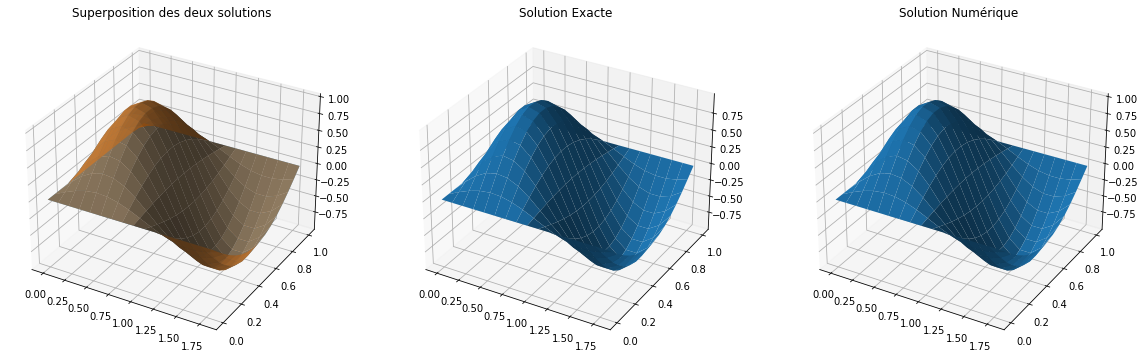

In [10]:
#Post-traintement u_ex+Visualization of the exct solution
uu_ex = np.reshape(u_ex, (nx+2, ny+2), order='F')
X, Y = np.meshgrid(xx, yy)
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X, Y, uu_ex.T, rstride=1, cstride=1)
ax1.plot_surface(X, Y, uu_num.T, rstride=1, cstride=1, alpha=0.5)
plt.title('Superposition des deux solutions')

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X, Y, uu_ex.T, rstride=1, cstride=1)
plt.title("Solution Exacte")

ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(X, Y, uu_num.T, rstride=1, cstride=1)
plt.title("Solution Numérique");


In [11]:
err_question5 = np.linalg.norm(uu_num - uu_ex) / np.linalg.norm(uu_ex)
print(f"Erreur de {err_question5:05f}")

Erreur de 0.006844


## Question 6

$$\begin{equation}
\begin{aligned}
-\mu \Delta u &=f \text { dans } \Omega \\
u &=0 \text { sur } \Gamma_{0} \\
\frac{\partial u}{\partial n} &=0 \text { sur } \Gamma_{1}
\end{aligned}
\end{equation}
$$

Sur $\Gamma_{1}=\{(a, y) \mid y \in[0, b]\}$, montrer que l’on a $$\frac{\partial u}{\partial x}(a, y)=\frac{4 u\left(a-h_{x}, y\right)-u\left(a-2 h_{x}, y\right)-3 u(a, y)}{2 h_{x}}+\mathcal{O}\left(h_{x}^{2}\right)$$

> Réponse
> 
> Pour $y_i$ fixé :
> 
> $x_{i-1} = x_i - h_x$
> $$u(x_i - h_x, y_j) = u(x_{i}, y_j) - h_x \frac{\partial u}{\partial x}(x_{i}, y_j) + \frac{h_x^2}{2} \frac{\partial^2 u}{\partial x^2}(x_{i}, y_j) - \frac{h_x^3}{6} \frac{\partial^3 u}{\partial x^3}(x_{i}, y_j) + \mathcal{O}(h_x^4)$$
> 
> $x_{i-1} = x_i - 2h_x$
> $$u(x_i - 2h_x, y_j) = u(x_{i}, y_j) - 2h_x \frac{\partial u}{\partial x}(x_{i}, y_j) + 2h_x^2 \frac{\partial^2 u}{\partial x^2}(x_{i}, y_j) - 8\frac{h_x^3}{6} \frac{\partial^3 u}{\partial x^3}(x_{i}, y_j) + \mathcal{O}(h_x^4)$$
> 
> Par somme (4 fois la première moins une fois la seconde)
> 
> $$4 u(x_i-h_{x}, y_j)-u\left(x_i-2 h_{x}, y_j\right)=3 u(x_i, y_j)-2 h_{x} \frac{\partial u}{\partial x}(x_i, y_j)+\mathcal{O}\left(h_{x}^{3}\right)$$
> 
> Pour $x_i = a$ et $y_j = y$ fixé, on obtient bien:
> $$\begin{equation}
\frac{\partial u}{\partial x}(a, y)=\frac{3 u(a, y)+u\left(a-2 h_{x}, y\right)-4 u\left(a-h_{x}, y\right)}{2 h_{x}}+\mathcal{O}\left(h_{x}^{2}\right)
\end{equation}$$


## Question 7

En déduire la modification à apporter sur $A$ pour prendre en compte cette condition de Neumann sur $Γ_1$ et vérifier vos résultats en considérant la solution $u(x, y) = \sin \left(\frac{\pi y}{b}\right)\left(\cos \left(\frac{\pi x}{a}\right)-1\right)$

In [12]:
#MATRICE C
def C(Nx):
    Cm = (-μ/hy**2)*np.eye((Nx+2))
    Cm[0, 0] = Cm[-1, -1] = 0
    return Cm

#MATRICE B


def B(Nx):
    Bm = μ*((2/hx**2)+(2/hy**2))*np.eye((Nx+2)) +\
        (-μ/hx**2)*np.roll(np.eye((Nx+2)), shift=1, axis=1) +\
        (-μ/hx**2)*np.roll(np.eye((Nx+2)), shift=-1, axis=1)
    Bm[0, 0] = 1
    Bm[0, 1] = Bm[0, -1] = 0
    Bm[-1, -2] = Bm[-1, 0] = 0
    # Ajout sur Gamma_1
    Bm[-1, -1] = -3/(2*hx)
    Bm[-1, -2] = 4/(2*hx)
    Bm[-1, -3] = -1/(2*hx)
    return Bm


#MATRICE A
def A(Nx, Ny):
    kronI = np.zeros((Ny+2, Ny+2))
    kronI[0, 0] = kronI[-1, -1] = 1
    Im = np.eye(Nx+2)

    kronC = np.roll(np.eye(Ny+2), shift=+1, axis=1) + \
        np.roll(np.eye(Ny+2), shift=-1, axis=1)
    kronC[0, -1] = kronC[-1, 0] = 0
    kronC[0, 1] = kronC[-1, -2] = 0
    Cm = C(Nx)

    kronB = np.eye(Ny+2)
    kronB[0, 0] = kronB[-1, -1] = 0
    Bm = B(Nx)
    Am = np.kron(kronI, Im) + np.kron(kronC, Cm) + np.kron(kronB, Bm)
    return Am


In [13]:
##  Solution and source terms
u = np.zeros((nx+2)*(ny+2)) #Numerical solution
u_ex = np.zeros((nx+2)*(ny+2)) #Exact solution
F = np.zeros((nx+2)*(ny+2)) #Source term
#
#

def Source_int(x):  # Laplacien
    return -μ*( \
        -np.pi**2* (np.sin(np.pi*x[1]/b) * np.cos(np.pi*x[0]/a) )/(a**2)  \
        -np.pi**2* (np.sin(np.pi*x[1]/b) * (np.cos(np.pi*x[0]/a) - 1))/(b**2) \
    )
def Source_bnd(x):  # Valeur boundary
    return 0.0

def Sol_sin(x):  # Sol
    return np.sin(np.pi*x[1]/b)*(np.cos(np.pi*x[0]/a) - 1)
for i in range(nptx):
    for j in range(npty):
        coord = np.array([i*hx,j*hy])
        u_ex[j*(nx+2) + i] = Sol_sin(coord)
    if i==0 or i==nptx-1: # Boundary x=0 ou x=xmax
        for j in range(npty):
            coord = np.array([i*hx,j*hy])
            F[j*(nx+2) + i]=Source_bnd(coord)
    else:
        for j in range(npty):
            coord = np.array([i*hx,j*hy])
            if j==0 or j==npty-1: # Boundary y=0 ou y=ymax
                F[j*(nx+2) + i]=Source_bnd(coord)
            else:
                F[j*(nx+2) + i]=Source_int(coord)

In [14]:
uu_num = np.linalg.solve(A(nx, ny), F)
uu_num = np.reshape(uu_num, (nx+2, ny+2), order='F')


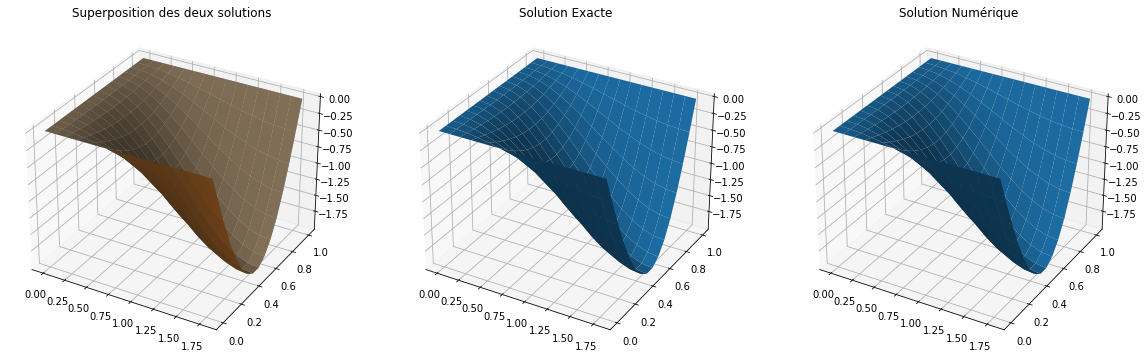

In [15]:
#Post-traintement u_ex+Visualization of the exct solution
uu_ex = np.reshape(u_ex, (nx+2, ny+2), order='F')
X, Y = np.meshgrid(xx, yy)
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X, Y, uu_ex.T, rstride=1, cstride=1)
ax1.plot_surface(X, Y, uu_num.T, rstride=1, cstride=1, alpha=0.5)
plt.title('Superposition des deux solutions')

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X, Y, uu_ex.T, rstride=1, cstride=1)
plt.title('Solution Exacte')

ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(X, Y, uu_num.T, rstride=1, cstride=1)
plt.title("Solution Numérique");


In [16]:
err_question7 = np.linalg.norm(uu_num - uu_ex) / np.linalg.norm(uu_ex)
print(f"Erreur de {err_question7:05f}")


Erreur de 0.003357


> On a $\forall j \in \{0 ,..., N_{y}+1 \}, \frac{3 u_{N_{x}+1, j}+u_{N_{x}-1, j}-4 u_{N_{x}, j}}{2 h_{x}}=0$,
> 
> On modifie donc légèrement les dernière lignes de $B$ pour prendre en compte la condition sur $\Omega_1$ avec :
```python
Bm[-1, -1] = -3/(2*hx)
Bm[-1, -2] = 4/(2*hx)
Bm[-1, -3] = -1/(2*hx)
```


> On voit sur les figures que la solution numérique correspond à celle exacte.

> L'erreur est de l'ordre de $10^{-2}$, notre implélementation semble correcte.

# Approximation des termes advectifs

Sous l’influence de l’écoulement de la rivière, les effets advectifs ont tendance à déplacer le produit dans le sens de $V$ . Comme on l’a vu, ces effets sont représentés par le terme de dérivée directionnelle $V\cdot \nabla u$. Considérons le problème de diffusion-advection stationnaire :

$$\begin{aligned}
-\mu \Delta u+V \cdot \nabla u &=f \text { dans } \Omega \\
u &=0 \text { sur } \Gamma_{0} \\
\frac{\partial u}{\partial n} &=0 \text { sur } \Gamma_{1}
\end{aligned}$$

avec $ V \in \mathbb{R}^{2}$

## Question 8

Dans ce problème, deux phénomènes physiques sont en intéraction : les **phénomènes diffusifs** et et les **phénomènes advectifs**. Afin de quantifier quel phénomène est prédominant sur l’autre, on introduit le **nombre de Péclet**. Soit $l$ une échelle de longueur caractéristique (par exemple le rayon de la tache de produit) et $v$ une échelle de vitesse (typiquement la norme de $V$). Par analyse dimensionnelle, montrer que le nombre de Péclet peut être défini par : 

$$\mathrm{Pe}_{\ell}=\frac{\ell v}{\mu}$$

Quel est le régime dominant si $\mathrm{Pe}_{\ell} \gg 1$ ? Montrer que l’on peut aussi définir ce nombre sous la forme $\mathrm{Pe}_{\ell}=\tau_{d} / \tau_{a}$ avec $\tau_{d}$ et $\tau_{a}$ les échelles de temps caractéristiques diffusifs et advectifs, respectivement.

> Réponse
> 
> - Les **phénomènes d'advection** sont modélisé par la composante $V \cdot \nabla U = v_x \nabla_x U + v_y \nabla_y U$ (dérivée directionnelle de $U$ dans la direction de la vitesse).
> 
> - Les **phénomènes diffusifs** sont modélisé par la composante $-\mu \Delta u$
> 
> On a donc, par analyse dimensionnelle: $P_{e_l} = \frac{\frac{V \times u}{L}}{\frac{\mu \times u}{L^2}} = \frac{V \times L}{\mu}$
> 
> Donc pour $P_{e_l} \gg 1$, le régime d'advection domine.
> 
> On pose $l v = \frac{1}{\tau_{a}}$ et $\mu = \frac{1}{\tau_{d}}$, par le même raisonnement qu'avant, le nombre de Péclet peut s'exprimer en fonction des échelles de temps, et suivant les cas $P_{e_l} \gg 1$ et $P_{e_l} \ll 1$ on saura quelle régime domine.

## Question 9

Montrer que si $V=\left(\begin{array}{c}
v_{x} \\
0
\end{array}\right)$

Alors : $$V \cdot \nabla u\left(x_{i}, y_{j}\right) = v_{x} \frac{u\left(x_{i+1}, y_{j}\right)-u\left(x_{i-1}, y_{j}\right)}{2 h_{x}}+\mathcal{O}\left(h_{x}^{2}\right)$$

En déduire la discrétisation du terme advectif et vérifier vos résultats dans le régime diffusif.

> 
> Pour $$V=\left(\begin{array}{c}
v_{x} \\
0
\end{array}\right)$$
> On à $\left\langle V, \nabla u\left(x_{i}, y_{j}\right)\right\rangle=v_{x} \frac{\partial u}{\partial x}\left(x_{i}, y_{j}\right)$.,
> 
> Avec un schéma centré sur $\frac{\partial u}{\partial x}\left(x_{i}, y_{j}\right)$ on obtient:
> $$\frac{\partial u}{\partial x}\left(x_{i}, y_{j}\right) \approx \frac{u\left(x_{i+1}, y_{j}\right)-u\left(x_{i-1}, y_{j}\right)}{2 h_{x}}$$
>
> Et donc : 
> $$\left(V, \nabla u\left(x_{i}, y_{j}\right)\right\rangle = v_{x} \frac{\partial u}{\partial x}\left(x_{i}, y_{j}\right) \approx \frac{v_{x}}{2 h_{x}}\left(u_{i+1, j}-u_{i-1, j}\right)$$
>
> On modélise alors la convection par l'ajout d'un partie de *convection* dans la matrice
> Avec $$Conv=\left[\begin{array}{ccc}
0 & & &  &0\\
0 & D & \\
& &\ddots  \\
0 & & & D \\
0 & & & & 0
\end{array}\right]$$
> Avec la matrice $D$, $$D= v_x \left[\begin{array}{ccccccc}
0 & \frac{+1}{h_x^2}& & & & & 0 \\
\frac{-1}{h_x^2} & 0 & \frac{+1}{h_x^2} & & & & \\
& \frac{-1}{h_x^2} & 0 & & & \\
& & & \ddots & & \\
& & & \frac{-1}{h_x^2} & 0 & \frac{+1}{h_x^2} \\
& & & & \frac{-1}{h_x^2} & 0 \\
& & & & & \frac{-1}{h_x^2} & 0 \\
0 & & & & & & & 0
\end{array}\right]$$
> On a donc $A + Conv$

# Marches en temps

Considérons maintenant le problème complet $(2)$. On note $A$ l’approximation de l’opérateur $C \mapsto-\mu \Delta C+V \cdot \nabla C$ avec les conditions au bord de type Dirichlet/Neumann. Le problème semi-discret en espace ainsi s’écrit sous la forme d’un problème de Cauchy :
$$\begin{aligned}
&\frac{d}{d t} \mathbf{U}(t)+\mathbf{A} \mathbf{U}(t)=0 \\
&\mathbf{U}(t=0)=\mathbf{U}_{0}
\end{aligned}$$

Dans la suite on prendra un coefficient de diffusion $µ = 0.01$ et on choisira pour condition initiale une Gaussienne centré en $(x_0, y_0)$, suffisament éloigné du bord $∂Ω$ et de rayon $r_0$ : $$C_{0}(x, y)=e^{-\left(\frac{x-x_{0}}{r_{0}}\right)^{2}-\left(\frac{y-y_{0}}{r_{0}}\right)^{2}}$$

L’ intervalle de temps pour notre étude sera $[0, T]$, avec $δt$ le pas de temps et $N_T$ le nombre de pas de temps (ie. $δt = \frac{T}{N_T}$ ). On notera également $t_n = nδt$ pour tout $n \in [0, N_T]$. L’approximation de la quantité $U(t_n)$ pour $n ≥ 1$ est notée $U_n$. 

L’objectif de cette dernière partie est de déterminer un "bon" schéma en temps en régime advectif.

## Question 10

Commençons par considérer l’équation de la chaleur, c’est à dire pour $v_x = 0$.

### Question 10.a

Écrire l’algorithme d’Euler explicite dans l’intérieur de $Ω$. Montrer en particulier
que $U^{n+1}_{i, j}$ est une combinaison convexe de $U_{i, j}^{n}$, $U_{i-1, j}^{n}$, $U_{i+1, j}^{n}$, $U_{i, j-1}^{n}$ et $U_{i, j+1}^{n}$ si : $$\mathrm{CFL}=\frac{\mu \delta t}{h_{x}^{2}}+\frac{\mu \delta t}{h_{y}^{2}} \leq \frac{1}{2} .$$

> Réponse
> 
> Pour $v_x = 0$, on avais sur l'intérieur de $\Omega$ la discrétisation en temps suivantes
> 
> $$\mu \bigg( \frac{2 u_{i, j}-u_{i-1, j}-u_{i+1, j}}{h_{x}^{2}} \bigg) + \mu \bigg( \frac{2 u_{i, j}-u_{i, j-1}-u_{i, j+1}}{h_{y}^{2}} \bigg) \approx f_{i,j}$$
> 
> Associé a une intégration temporelle d'Euler Explicite cela donne:
> $$\begin{equation}
\frac{u_{i, j}^{n+1}-u_{i, j}^{n}}{dt}+\mu\left(\frac{2 u_{i, j}^{n}-u_{i-1, j}^{n}-u_{i+1, j}^{n}}{h_{x}^{2}}+\frac{2 u_{i, j}^{n}-u_{i, j-1}^{n}-u_{i, j+1}^{n}}{h_{y}^{2}}\right)=0
\end{equation}$$
> 
> Avec Euler Explicite on à donc $u_{i, j}^{n+1}$ qui s'écris de façon explicite avec les $u_{i,j}^{n}$ précédent:
> $$\begin{equation}
u_{i, j}^{n+1}=\left(1-\frac{2 \mu d t}{h_{x}^{2}}-\frac{2 \mu dt}{h_{y}^{2}}\right) u_{i, j}^{n}+\frac{\mu dt}{h_{x}^{2}} u_{i+1, j}^{n}+\frac{\mu dt}{h_{x}^{2}} u_{i-1, j}^{n}+\frac{\mu dt}{h_{y}^{2}} u_{i, j+1}^{n}+\frac{\mu dt}{h_{y}^{2}} u_{i, j-1}^{n}
\end{equation}$$
>
> Soit $\alpha_1 = \left(1-\frac{2 \mu dt}{h_{x}^{2}}-\frac{2 \mu dt}{h_{y}^{2}}\right)$, $\alpha_2 = \frac{\mu dt}{h_{x}^{2}}$ et $\alpha_3 = \frac{\mu dt}{h_{y}^{2}}$
> Donc: 
> $$\begin{equation}
u_{i, j}^{n+1}= \alpha_1 u_{i, j}^{n}+ \alpha_2 u_{i+1, j}^{n}+ \alpha_2 u_{i-1, j}^{n}+ \alpha_3 u_{i, j+1}^{n}+ \alpha_3 u_{i, j-1}^{n}
\end{equation}$$
>
> La condition pour avoir un combinaison convexe est donc $\alpha_{1}+2 \alpha_{2}+2 \alpha_{3}=1$, avec les $\alpha_i$ positif
> Cette condition impose donc $$CFL= \alpha_2 + \alpha_3 = \frac{\mu dt}{h_{x}^{2}}+\frac{\mu dt}{h_{y}^{2}} \leq \frac{1}{2} $$

### Question 10.b

Verifier cette condition CFL en pratique. Que pensez-vous de cette condition ?

> Réponse
> 
> Dans la pratique cette condition nous fait perdre un degré de liberté dans le choix des paramètres $\mu$, $h_x$, $h_y$ et $dt$.
> Par exemple si on définis notre maillage en espace ($h_x$ et $h_y$), que notre $\mu$ est un paramêtre physique fixé alors le pas de temps nous est imposé (il faut qu'il soit donc plus petit que $\frac{2\mu}{h_{x}^{2}}+\frac{2\mu}{h_{y}^{2}}$)

### Question 10.c

Dans l’objectif d’intégrer par la suite les phénomènes advectifs, on va considérer le schéma de Crank-Nicholson. Quelle est la particularité de ce schéma dans le cas de l’équation de la chaleur ? (On pourra reprendre l’analyse de stabilité par la méthode de Fourier dans le cas 1D).

> Réponse
> 
> Le schéma de Crank-Nicholson (intégration temporelle et spatial associé): $$\frac{u_{i}^{n+1}-u_{i}^{n}}{\delta t}=\frac{\mu}{2 h_{x}^{2}}\left(u_{i+1}^{n+1}-2 u_{i}^{n+1}+u_{i-1}^{n+1}+u_{i+1}^{n}-2 u_{i}^{n}+u_{i-1}^{n}\right)$$
> 
> Dans le cas d'une étude sur des fonction périodique on pose : $u_{i}^{n}=A^{n} e^{j i \varphi}$ (décompisition de Fourier) et le nombre de courant $C=\frac{\mu dt}{h_{x}^{2}}$.
> L'étude nous donne ainsi : $\frac{A^{n+1}}{A^{n}}= G = \frac{1+\mathcal{C}(\cos (\varphi)-1)}{1+\mathcal{C}(1-\cos (\varphi))}$.
> Le schéma est donc inconditionnellement stable avec $|G|≤1$ pour n'importe tout $C$.
> 
> Dans le cas particulier de l'équation de la Chaleur, Crank-Nicholson est donc inconditionnellement stable.

## Question 11

Appliquer le schéma de Crank-Nicholson en présence d’un champs advectif $V = (1, 0)$. Quel est le régime de l’écoulement ? Pourquoi il n’est pas raisonnable de considérer le schéma d’Euler ?

> Réponse
>
> Comme vu dans la Question 8, pour un coefficient $\mu$ faible ($\ll l v$), $P e_{l} \gg 1$, le régime est dominant est le régime advectif. L'équation (3), $\frac{\partial C}{\partial t}-\mu \Delta C+\langle V, \nabla C\rangle=0$, devient alors $\frac{\partial C}{\partial t} + \langle V, \nabla C\rangle=0$. Le régime d'écoulement serait advectif (selon l'axe $ + O_x$).
> 
> En réutilisant la discrétisation spatial du terme advectif de la Question 9 et le schéma d'Euler l'étude par la méthode de Fourier 1D nous donne:
> 
> On a ainsi $\frac{A^{n+1}}{A^{n}}=1-j C \sin (\varphi)$, dont le module vaut $|G|= \sqrt{1+ C^{2} \sin ^{2}(\varphi)}>1$. Le schéma est donc inconditionellement instable.
> 
> Il est donc particulièrement déraisonnable de considérer le schéma d'Euler.

## Question 12

On choisit $r_0 = 0.1$, $x_0 = 0.25$ et $y_0 = 0.5$ sur $\Omega=] 0,2[\times] 0,1[$. Au bout de combien de temps la concentration a t-elle diminuée de $80\%$ ?

> Réponse
> 
> Avec `Concentration_Modia.py`
> 
> En modifiant les paramêtres suivant:
> `s0 = 0.1`, `x0 = 0.25`, `y0 = 0.5`, `xmin = 0.0; xmax = 2.0;` et `ymin = 0.0; ymax = 1.0`.
> 
> Et la méthode d'intégration temporelle de Crank-Nikolson sur `Sol_init`.
>
> La concentration est diminuée de 80% pour environ $t=0.75$ sec
> ![$t=0$ sec](./imgs/im1.png)
> ![$t=0.7$ sec](./imgs/im2.png)
> ![$t=0.75$ sec](./imgs/im3.png)

## Question 13

Effectuer de même pour une condition initiale moins régulière :

$$C_{0}(x, y)=\left\{\begin{array}{l}
r_{0}^{2}-\left(x-x_{0}\right)^{2}-\left(y-y_{0}\right)^{2} \text { si } r_{0}^{2}-\left(x-x_{0}\right)^{2}-\left(y-y_{0}\right)^{2}>0 \\
0 \text { sinon }
\end{array}\right.$$

> Réponse
> 
> On remarque effectivement que la fonction a tendance à être lissée et atténuée.
>
> Par exemple avec `s0 = 0.1`, `x0 = 0.2`, `y0 = 0.2`, `xmin = 0.0; xmax = 2.0;` et `ymin = 0.0; ymax = 1.0`.
> Et la méthode d'intégration temporelle de Crank-Nikolson sur `Sol_init2`.
>
> ![$t=0.0$ sec](./imgs/im4.png)
> ![$t=0.0$ sec](./imgs/im5.png)
> 